<a href="https://colab.research.google.com/github/zmohaghegh/Facial-Age-Prediction-Landmarks-GLCM/blob/main/Age_Prediction_FGNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 در حال آماده‌سازی دیتاست و مدل‌ها...
Using Colab cache for faster access to the 'fgnet-dataset' dataset.
🔄 شروع پردازش 1002 تصویر واقعی از FG-NET...
✅ پردازش تمام شد. 979 نمونه با موفقیت استخراج شد.
🧠 در حال آموزش مدل SVR (ممکن است چند لحظه طول بکشد)...

📊 نتایج نهایی روی دیتاست FG-NET:
Mean Absolute Error (MAE): 5.99 years
R2 Score: 0.54


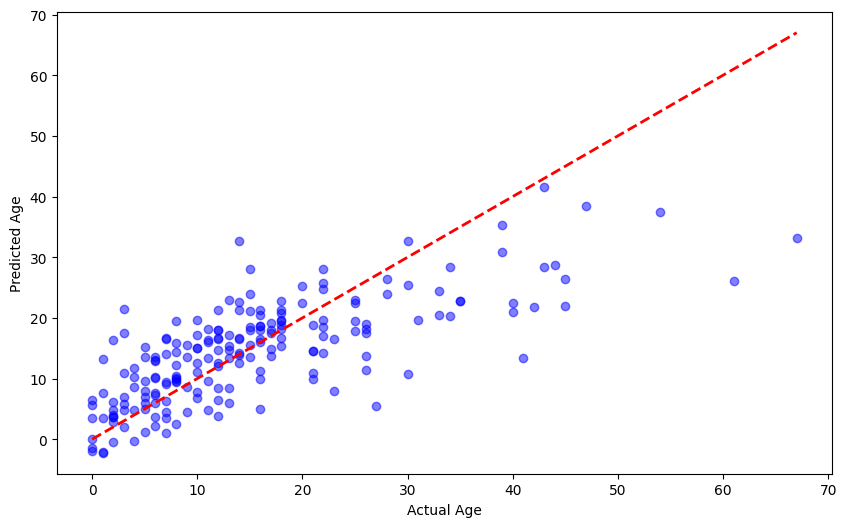

In [10]:

# ۱. نصب کتابخانه‌های مورد نیاز
!pip install kagglehub dlib opencv-python scikit-image

import os
import cv2
import dlib
import numpy as np
import glob
import kagglehub
import zipfile
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- ۲. تنظیمات و دانلود دیتاست ---
print("📥 در حال آماده‌سازی دیتاست و مدل‌ها...")
# دانلود خودکار از کاگل با استفاده از کد ارسالی شما
path = kagglehub.dataset_download("aiolapo/fgnet-dataset")
# بر اساس خروجی listdir شما، مسیر دقیق تصاویر اینجاست:
image_folder = os.path.join(path, "FGNET", "images")

# دانلود مدل پیش‌بینی ۶۸ نقطه صورت (معادل Chehra)
if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
    print("📥 در حال دانلود مدل لاندمارک Dlib...")
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bunzip2 shape_predictor_68_face_landmarks.dat.bz2

# بارگذاری مدل‌های شناسایی
detector = dlib.get_frontal_face_detector() # Viola-Jones
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat') # Landmarks

# --- ۳. تابع اصلی استخراج ویژگی (Hybrid: Geometry + Texture) ---
def extract_hybrid_features(img_path):
    img = cv2.imread(img_path)
    if img is None: return None

    # بهبود کیفیت تصویر برای شناسایی بهتر
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    # شناسایی چهره (Viola-Jones) - ضریب 1 برای دقت بیشتر در تصاویر ریز
    faces = detector(gray, 1)
    if len(faces) == 0: return None

    face = faces[0]

    try:
        # الف) استخراج ویژگی‌های هندسی (Chehra/Landmarks)
        shape = predictor(gray, face)
        landmarks = []
        for n in range(68):
            landmarks.extend([shape.part(n).x, shape.part(n).y])

        # ب) استخراج ویژگی‌های بافت (GLCM)
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        img_h, img_w = gray.shape
        y1, y2 = max(0, y), min(img_h, y+h)
        x1, x2 = max(0, x), min(img_w, x+w)

        face_roi = gray[y1:y2, x1:x2]
        if face_roi.size < 100: return None

        # کاهش سطوح خاکستری برای محاسبه GLCM
        face_roi = (face_roi // 16).astype(np.uint8)
        glcm = graycomatrix(face_roi, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=16, symmetric=True, normed=True)

        texture = [
            graycoprops(glcm, 'contrast').mean(),
            graycoprops(glcm, 'homogeneity').mean(),
            graycoprops(glcm, 'energy').mean(),
            graycoprops(glcm, 'correlation').mean()
        ]

        # ترکیب هر دو دسته ویژگی در یک بردار
        return np.hstack((landmarks, texture))
    except:
        return None

# --- ۴. پردازش کل تصاویر موجود در پوشه تصاویر FG-NET ---
X, y = [], []
image_files = glob.glob(os.path.join(image_folder, "*.[jJ][pP][gG]"))

print(f"🔄 شروع پردازش {len(image_files)} تصویر واقعی از FG-NET...")

for f in image_files:
    name = os.path.basename(f)
    try:
        # استخراج سن از نام فایل: مثلا 020a18.jpg -> سن 18
        if 'a' in name.lower():
            age_part = name.lower().split('a')[1]
            age = int(''.join(filter(str.isdigit, age_part))[:2])

            feat = extract_hybrid_features(f)
            if feat is not None:
                X.append(feat)
                y.append(age)
    except:
        continue

X, y = np.array(X), np.array(y)

# --- ۵. بخش رگرسیون و نمایش نتایج (SVR) ---
if len(X) > 0:
    print(f"✅ پردازش تمام شد. {len(X)} نمونه با موفقیت استخراج شد.")

    # تقسیم داده‌ها به آموزش و تست
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # نرمال‌سازی داده‌ها (بسیار مهم برای SVR)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # تعریف و آموزش مدل SVR
    print("🧠 در حال آموزش مدل SVR (ممکن است چند لحظه طول بکشد)...")
    model = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
    model.fit(X_train, y_train)

    # پیش‌بینی
    preds = model.predict(X_test)

    # محاسبه خطا
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"\n📊 نتایج نهایی روی دیتاست FG-NET:")
    print(f"Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"R2 Score: {r2:.2f}")

    # رسم نمودار مقایسه
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, color='blue', alpha=0.5, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")